In [1]:
import kagglehub
import pandas as pd
import pennylane as qml
from pennylane import numpy as pnp
from sklearn.preprocessing import StandardScaler
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.decomposition import PCA
from itertools import product


from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
)

import time
from sklearn.metrics import roc_curve, RocCurveDisplay, roc_auc_score
import pickle
from datetime import datetime

SEED = 123

## Download latest version
path = kagglehub.dataset_download("sameepvani/nasa-nearest-earth-objects")

/Users/theodorbjork/DD2368/DD2368/Project/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

df = pd.read_csv(f"{path}/neo.csv")
df.head()

,id,name,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,orbiting_body,sentry_object,absolute_magnitude,hazardous
0,2162635,162635 (2000 SS164),1.198271,2.679415,13569.249224,5.483974e+07,Earth,False,16.73,False
1,2277475,277475 (2005 WK4),0.265800,0.594347,73588.726663,6.143813e+07,Earth,False,20.00,True
2,2512244,512244 (2015 YE18),0.722030,1.614507,114258.692129,4.979872e+07,Earth,False,17.83,False
3,3596030,(2012 BV13),0.096506,0.215794,24764.303138,2.543497e+07,Earth,False,22.20,False
4,3667127,(2014 GE35),0.255009,0.570217,42737.733765,4.627557e+07,Earth,False,20.09,True


In [3]:
features = ['est_diameter_min', 'est_diameter_max', 'relative_velocity', 'miss_distance','absolute_magnitude']
target = 'hazardous'

#Reducera dimension

In [4]:
df.iloc[[10,11]]

,id,name,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,orbiting_body,sentry_object,absolute_magnitude,hazardous
10,54049873,(2020 OT6),0.252671,0.564989,58430.697200,3.833750e+07,Earth,False,20.11,True
11,54099949,(2020 XW4),0.152952,0.342011,64393.928316,7.198311e+07,Earth,False,21.20,False


In [5]:
mask = df[target] == True

In [6]:
N = 8840
np.random.seed(SEED)

df_true = df[df[target] == True]
df_false = df[df[target] == False]

df_subset_true = df_true.iloc[np.random.choice(N, size=N, replace=False)]
df_subset_false = df_false.iloc[np.random.choice(N, size=N, replace=False)]

df_subset = pd.concat([df_subset_true, df_subset_false])



In [7]:

from sklearn.model_selection import train_test_split

# Split the dataframe into 80% train and 20% test
train_df, test_df = train_test_split(
    df_subset,
    test_size=0.2,
    random_state=1,
    stratify=df_subset['hazardous']
)

# Optionally display the shapes of the train and test sets
print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")



Train shape: (14144, 10)
Test shape: (3536, 10)


In [8]:
from sklearn.model_selection import train_test_split

# Split train_df further into 80% train and 20% validation, stratified on 'hazardous'
train_split_df, val_df = train_test_split(
    train_df,
    test_size=0.2,
    random_state=1,
    stratify=train_df['hazardous']
)

# Optionally, print the shapes
print(f"Train split shape: {train_split_df.shape}")
print(f"Validation shape: {val_df.shape}")


Train split shape: (11315, 10)
Validation shape: (2829, 10)


In [9]:
train_split_df[features].head()

,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,absolute_magnitude
6870,0.201630,0.450858,50378.129004,4.473852e+07,20.60
40207,0.136319,0.304818,57258.634964,5.595927e+07,21.45
21865,0.133216,0.297879,79706.183096,1.037284e+07,21.50
70017,0.139494,0.311918,23500.785784,5.472054e+07,21.40
77140,0.160160,0.358129,79681.217623,1.548794e+07,21.10


In [10]:

X_train, Y_train = train_split_df[features].to_numpy(), train_split_df[target].apply(lambda x: int(x)).to_numpy()
X_val, Y_val = val_df[features].to_numpy(), val_df[target].apply(lambda x: int(x)).to_numpy()
X_test, Y_test = test_df[features].to_numpy(), test_df[target].apply(lambda x: int(x)).to_numpy()


In [11]:
y = np.where(Y_train==1, +1, -1)

scaler = StandardScaler()
X_tr = scaler.fit_transform(X_train)
X_vl = scaler.transform(X_val)
X_te = scaler.transform(X_test)

# n_qubits = 4

# if n_qubits < 5:
#     pca = PCA(n_components=n_qubits).fit(X_tr)
#     X_tr_red = pca.transform(X_tr)
#     X_val_red = pca.transform(X_vl)
#     X_te_red = pca.transform(X_te)
# else:
#     X_tr_red = X_tr
#     X_val_red = X_vl
#     X_te_red = X_te




# print("Shapes:", X_tr_red.shape, X_te_red.shape, " (+1 count):", (Y_train==+1).sum(), " (-1 count):", (Y_train==-1).sum())

In [12]:
#n_qubits = 5

# 1. Define a device with n_qubits wires in analytic mode (shots=None)
# -----YOUR CODE HERE-----
#dev = qml.device("default.qubit", wires=n_qubits, shots=None)
# ---YOUR CODE ENDS HERE---

def feature_map_qnn(x, scale=1.0, entangle=True):
    """
    Simple angle-embedding feature map with optional entangling layer.

    x: 1D array-like of length n_qubits (PCA-reduced input)
    scale: rescaling factor for angles
    entangle: if True, apply a CZ ring after single-qubit rotations
    """
    # -----YOUR CODE HERE-----
    wires = list(range(len(x)))
    # 1. Apply AngleEmbedding with rotation="Y" and the given scale
    qml.AngleEmbedding(x*scale, wires=wires, rotation="Y")

    # 2. If entangle=True, apply a ring of CZ or CNOT gates
    if entangle:
        for i in range(len(wires)-1):
            qml.CZ(wires[i:i+1+1])
        qml.CZ([wires[-1], wires[0]])
    # ---YOUR CODE ENDS HERE---
    return

def feature_map_qnn1(x, scale=1.0, entangle=True):
    # -----YOUR CODE HERE-----
    wires = list(range(len(x)))
    # 1. Apply AngleEmbedding with rotation="Y" and the given scale
    qml.AngleEmbedding(x*scale, wires=wires, rotation="Y")

    # 2. If entangle=True, apply a ring of CZ or CNOT gates
    if entangle:
        for i in range(len(wires)-1):
            qml.CZ(wires[i:i+1+1])
        qml.CZ([wires[-1], wires[0]])
    # ---YOUR CODE ENDS HERE---
    return

def feature_map_qnn2(x, scale=1.0, entangle=True):
    wires = list(range(len(x)))
    qml.IQPEmbedding(features=x, wires=wires, n_repeats=1, pattern=None)

    return 

def variational_ansatz1(theta):

    if theta.ndim != 2:
        raise ValueError(f"Expected theta to be 2D (ndim=2), got ndim={theta.ndim}")
    
    n_layers, n_wires = theta.shape


    wires = list(range(n_wires))
    for l in range(n_layers):
        qml.AngleEmbedding(theta[l], wires=wires, rotation="Y")
        for i in range(len(wires)-1):
            qml.CZ(wires[i:i+1+1])
        qml.CZ([wires[-1], wires[0]])

def variational_ansatz2(theta):

    if theta.ndim != 3:
        raise ValueError(f"Expected theta to be 3D (ndim=3), got ndim={theta.ndim}")
    
    num_rotations, n_layers, n_wires = theta.shape

    if num_rotations != 2:
        raise ValueError(f"Expected num_rotations to be 2, got {num_rotations}")


    wires = list(range(n_wires))
    for l in range(n_layers):
        qml.AngleEmbedding(theta[0, l], wires=wires, rotation="X")
        qml.AngleEmbedding(theta[1, l], wires=wires, rotation="Y")
        if l != n_layers-1:
            for i in range(len(wires)-1):
                qml.CZ(wires[i:i+1+1])
            qml.CZ([wires[-1], wires[0]])
    
def observable1(num_wires):
    return qml.expval(qml.PauliZ(0))

def observable2(num_wires):
    # Sum of all Z observables, properly scaled
    # Use len(dev.wires) instead of dev.num_wires for lightning.qubit compatibility
    obs = qml.sum(*[qml.PauliZ(i) for i in range(num_wires)]) / num_wires
    return qml.expval(obs)

def observable3(num_wires):
    obs = qml.PauliZ(0)
    for i in range(1, num_wires):
        obs = obs @ qml.PauliZ(i)
    return qml.expval(obs)


def variational_ansatz(theta):
    """
    Variational circuit with trainable parameters theta.
    
    theta: parameters with shape (number of layers, number of wires).

    Structure:
    - For each layer:
        - Apply RY rotations on all qubits
        - Apply a ring of CNOTs to entangle the qubits
    """
    n_layers, n_wires = theta.shape
    # -----YOUR CODE HERE-----
    wires = list(range(n_wires))
    for l in range(n_layers):
        qml.AngleEmbedding(theta[l], wires=wires, rotation="Y")

        if l != n_layers-1:
            for i in range(len(wires)-1):
                qml.CZ(wires[i:i+1+1])
            qml.CZ([wires[-1], wires[0]])
    # ---YOUR CODE ENDS HERE---
    return

# print(qml.draw(feature_map_qnn)(Xtr_red[0]))
# dev.wires

In [13]:
#HYPERPARAMETERS

PCA_DIMS = [3,4]
EMBEDDING_UNITARIES = [feature_map_qnn1, feature_map_qnn2]
VARIATIONAL_ANSWATZ = [variational_ansatz1, variational_ansatz2]
layer_specifications= {variational_ansatz1.__name__ : 1, variational_ansatz2.__name__ : 2}
OBSERVABLES = [observable1, observable2, observable3]

N_EPOCH = 10




In [14]:
# ============================================
# VALIDATION CELL: Test all components before grid search
# ============================================

print("=" * 60)
print("VALIDATING ALL GRID SEARCH COMPONENTS")
print("=" * 60)

all_passed = True

# Test each PCA dimension
for pca_dim in PCA_DIMS:
    print(f"\n--- Testing with PCA_DIM = {pca_dim} ---")
    
    # Create test device and sample data
    test_dev = qml.device("lightning.qubit", wires=pca_dim)
    test_x = torch.randn(pca_dim, dtype=torch.double)
    
    # Test each embedding
    for emb_fn in EMBEDDING_UNITARIES:
        try:
            @qml.qnode(test_dev, interface="torch")
            def test_embedding(x):
                emb_fn(x)
                return qml.expval(qml.PauliZ(0))
            
            _ = test_embedding(test_x)
            print(f"  ✅ {emb_fn.__name__} - OK")
        except Exception as e:
            print(f"  ❌ {emb_fn.__name__} - FAILED: {e}")
            all_passed = False
    
    # Test each variational ansatz
    for var_fn in VARIATIONAL_ANSWATZ:
        try:
            n_layers = layer_specifications[var_fn.__name__]
            if var_fn.__name__ == "variational_ansatz1":
                test_theta = torch.randn(n_layers, pca_dim, dtype=torch.double)
            else:  # variational_ansatz2
                test_theta = torch.randn(2, n_layers, pca_dim, dtype=torch.double)
            
            @qml.qnode(test_dev, interface="torch")
            def test_ansatz(theta):
                var_fn(theta)
                return qml.expval(qml.PauliZ(0))
            
            _ = test_ansatz(test_theta)
            print(f"  ✅ {var_fn.__name__} (theta shape: {tuple(test_theta.shape)}) - OK")
        except Exception as e:
            print(f"  ❌ {var_fn.__name__} - FAILED: {e}")
            all_passed = False
    
    # Test each observable (now takes num_wires as parameter)
    for obs_fn in OBSERVABLES:
        try:
            @qml.qnode(test_dev, interface="torch")
            def test_observable(n_wires):
                # Apply some gates first (observables need a circuit)
                for i in range(n_wires):
                    qml.RY(0.5, wires=i)
                return obs_fn(n_wires)
            
            result = test_observable(pca_dim)
            print(f"  ✅ {obs_fn.__name__} - OK (returned: {result:.4f})")
        except Exception as e:
            print(f"  ❌ {obs_fn.__name__} - FAILED: {e}")
            all_passed = False

# Test complete circuit combinations
print(f"\n--- Testing Complete Circuit Combinations ---")
for pca_dim in PCA_DIMS:
    test_dev = qml.device("lightning.qubit", wires=pca_dim)
    test_x = torch.randn(pca_dim, dtype=torch.double)
    
    for emb_fn in EMBEDDING_UNITARIES:
        for var_fn in VARIATIONAL_ANSWATZ:
            for obs_fn in OBSERVABLES:
                try:
                    n_layers = layer_specifications[var_fn.__name__]
                    if var_fn.__name__ == "variational_ansatz1":
                        test_theta = torch.randn(n_layers, pca_dim, dtype=torch.double)
                    else:
                        test_theta = torch.randn(2, n_layers, pca_dim, dtype=torch.double)
                    
                    # Capture pca_dim in closure for this iteration
                    num_wires = pca_dim
                    
                    @qml.qnode(test_dev, interface="torch", diff_method="adjoint")
                    def test_full_circuit(x, theta):
                        emb_fn(x)
                        var_fn(theta)
                        return obs_fn(num_wires)
                    
                    result = test_full_circuit(test_x, test_theta)
                    
                    # Also test that gradients work
                    test_theta.requires_grad = True
                    result = test_full_circuit(test_x, test_theta)
                    result.backward()
                    
                    config_name = f"{pca_dim}_{emb_fn.__name__}_{var_fn.__name__}_{obs_fn.__name__}"
                    print(f"  ✅ {config_name}")
                except Exception as e:
                    config_name = f"{pca_dim}_{emb_fn.__name__}_{var_fn.__name__}_{obs_fn.__name__}"
                    print(f"  ❌ {config_name} - FAILED: {e}")
                    all_passed = False

print("\n" + "=" * 60)
if all_passed:
    print("🎉 ALL TESTS PASSED! Ready to run grid search.")
else:
    print("⚠️  SOME TESTS FAILED! Fix issues before running grid search.")
print("=" * 60)


VALIDATING ALL GRID SEARCH COMPONENTS

--- Testing with PCA_DIM = 3 ---
  ✅ feature_map_qnn1 - OK
  ✅ feature_map_qnn2 - OK
  ✅ variational_ansatz1 (theta shape: (1, 3)) - OK
  ✅ variational_ansatz2 (theta shape: (2, 2, 3)) - OK
  ✅ observable1 - OK (returned: 0.8776)
  ✅ observable2 - OK (returned: 0.8776)
  ✅ observable3 - OK (returned: 0.6759)

--- Testing with PCA_DIM = 4 ---
  ✅ feature_map_qnn1 - OK
  ✅ feature_map_qnn2 - OK
  ✅ variational_ansatz1 (theta shape: (1, 4)) - OK
  ✅ variational_ansatz2 (theta shape: (2, 2, 4)) - OK
  ✅ observable1 - OK (returned: 0.8776)
  ✅ observable2 - OK (returned: 0.8776)
  ✅ observable3 - OK (returned: 0.5931)

--- Testing Complete Circuit Combinations ---
  ✅ 3_feature_map_qnn1_variational_ansatz1_observable1
  ✅ 3_feature_map_qnn1_variational_ansatz1_observable2
  ✅ 3_feature_map_qnn1_variational_ansatz1_observable3
  ✅ 3_feature_map_qnn1_variational_ansatz2_observable1
  ✅ 3_feature_map_qnn1_variational_ansatz2_observable2
  ✅ 3_feature_map_

In [ ]:
device_torch = "cuda" if torch.cuda.is_available() else "cpu"
results = {}
configs = list(product(PCA_DIMS, EMBEDDING_UNITARIES, VARIATIONAL_ANSWATZ, OBSERVABLES))

for pca_dim, embedding_unitary, var_ansatz, observable in tqdm(configs, desc="Grid Search"):
    
    torch.manual_seed(SEED)
    np.random.seed(SEED)
    
    print("--------------------------------")
    print(f"Running grid search combination: PCA_DIM={pca_dim}, EMBEDDING_UNITARY={embedding_unitary.__name__}, VARIATIONAL_ANSATZ={var_ansatz.__name__}, OBSERVABLE={observable.__name__}")

                
    dev = qml.device("lightning.qubit", wires=pca_dim)
    theta_shape_dict = {variational_ansatz1 : (layer_specifications[variational_ansatz1.__name__], pca_dim), variational_ansatz2 : (2, layer_specifications[variational_ansatz2.__name__], pca_dim)}

    pca = PCA(n_components=pca_dim).fit(X_tr)
    X_tr_red = pca.transform(X_tr)
    X_val_red = pca.transform(X_vl)
    X_te_red = pca.transform(X_te)

    batch_size = 32
    train_ds = TensorDataset(
        torch.tensor(X_tr_red, dtype=torch.double),
        torch.tensor(Y_train, dtype=torch.double).unsqueeze(1),
    )
    val_ds = TensorDataset(
        torch.tensor(X_val_red, dtype=torch.double),
        torch.tensor(Y_val, dtype=torch.double).unsqueeze(1),
    )
    test_ds = TensorDataset(
        torch.tensor(X_te_red, dtype=torch.double),
        torch.tensor(Y_test, dtype=torch.double).unsqueeze(1),
    )

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)


    num_wires = pca_dim
    @qml.qnode(dev, interface="torch", diff_method="adjoint")
    def qnn_circuit(x, theta):
        embedding_unitary(x)
        var_ansatz(theta)
        return observable(num_wires)

    class QNNClassifier(nn.Module):
        def __init__(self, theta_shape):
            super().__init__()

            self.theta = nn.Parameter(torch.randn(theta_shape) * 0.01)

            #self.theta = nn.Parameter(torch.empty(theta_shape, dtype=torch.double))
            #nn.init.xavier_uniform_(self.theta)

        def forward(self, x):
            if len(x.shape) == 1:
                x = x.unsqueeze(0)
            assert len(x.shape) == 2
            batch_size, n_qubits = x.shape
            exps = []
            for i in range(batch_size):
                exps.append(qnn_circuit(x[i], self.theta))

            output = (torch.stack(exps) + 1)/2
            return output.unsqueeze(-1)
    
    theta_shape = theta_shape_dict[var_ansatz]
    print("Theta shape for current configuration:", theta_shape)

    model = QNNClassifier(theta_shape).to(device_torch)


    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.02)

    n_epochs = N_EPOCH
    
    # Early stopping parameters
    patience = 3
    best_val_loss = float('inf')
    best_model_state = None
    patience_counter = 0
    best_epoch = 0

    history = {"loss": [], "val_loss": []}

    epoch_times = []
    for epoch in range(1, n_epochs + 1):
        start_time = time.time()
        model.train()
        epoch_loss = 0.0

        for xb, yb in train_loader:
            xb = xb.to(device_torch)
            yb = yb.to(device_torch)

            optimizer.zero_grad()
            out = model(xb).float()  # Convert to float32 for BCELoss
            yb_float = yb.float()
            loss = criterion(out, yb_float)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item() * xb.size(0)
        epoch_loss /= len(train_loader.dataset)
        end_time = time.time()
        epoch_times.append(end_time - start_time)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for xb, yb in val_loader:
                preds = model(xb).float()
                loss = criterion(preds, yb.float())
                val_loss += loss.item() * xb.size(0)
        val_loss /= len(val_loader.dataset)

        history["loss"].append(epoch_loss)
        history["val_loss"].append(val_loss)
        
        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = {k: v.clone() for k, v in model.state_dict().items()}
            best_epoch = epoch
            patience_counter = 0
            print(f"Epoch {epoch:02d}/{n_epochs} - loss: {epoch_loss:.4f} - val_loss: {val_loss:.4f} ✓ (best)")
        else:
            patience_counter += 1
            print(f"Epoch {epoch:02d}/{n_epochs} - loss: {epoch_loss:.4f} - val_loss: {val_loss:.4f} (patience: {patience_counter}/{patience})")
            
            if patience_counter >= patience:
                print(f"Early stopping triggered at epoch {epoch}. Best epoch: {best_epoch}")
                break
    
    # Restore best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print(f"Restored best model from epoch {best_epoch} with val_loss: {best_val_loss:.4f}")

    avg_epoch_time = sum(epoch_times) / len(epoch_times)
    print(f"Average epoch time: {avg_epoch_time:.4f} seconds")

    model.eval()
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(device_torch)
            yb = yb.to(device_torch)

            probs = model(xb)  # (batch_size, 1)
            all_probs.append(probs.cpu())
            all_labels.append(yb.cpu())

    all_probs = torch.cat(all_probs, dim=0)
    all_labels = torch.cat(all_labels, dim=0)

    # Convert probabilities to class predictions
    y_pred = (all_probs >= 0.5).int()
    y_true = all_labels.int()

    acc = accuracy_score(y_true.numpy(), y_pred.numpy())
    cm = confusion_matrix(y_true.numpy(), y_pred.numpy())

    print(f"Test accuracy: {acc:.3f}")
    print("Confusion matrix [[TN, FP], [FN, TP]]:")
    print(cm)

    #disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    #disp.plot(cmap="Blues")
    #plt.show()

    print(classification_report(y_true.numpy(), y_pred.numpy()))

    #plt.figure()
    # Compute ROC curve and ROC area for model
    #fpr, tpr, thresholds = roc_curve(y_true.numpy(), all_probs.numpy())
    roc_auc = roc_auc_score(y_true.numpy(), all_probs.numpy())

    print(f"ROC-AUC: {roc_auc:.3f}")

    #roc_disp = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
    #roc_disp.plot()
    #plt.show()
    # Save relevant results to a dictionary
    results[f"{pca_dim}_{embedding_unitary.__name__}_{var_ansatz.__name__}_{observable.__name__}"] = {
        "test_accuracy": acc,
        "confusion_matrix": cm.tolist(),
        "roc_auc": float(roc_auc),
        "classification_report": classification_report(y_true.numpy(), y_pred.numpy(), output_dict=True),
        "history": history,
        "avg_epoch_time": avg_epoch_time,
        "theta_shape": theta_shape,
        "theta": model.theta.detach().cpu().numpy(),
        "max_epochs": n_epochs,
        "best_epoch": best_epoch,
        "best_val_loss": best_val_loss,
        "early_stopped": patience_counter >= patience,
        "layer_specifications": layer_specifications,
        "PCA_DIM": pca_dim,
        "EMBEDDING_UNITARY": embedding_unitary.__name__,
        "VARIATIONAL_ANSWATZ": var_ansatz.__name__,
        "OBSERVABLE": observable.__name__,
    }

    # Save results with timestamped filename
    # now = datetime.now()
    # timestamp = now.strftime("%Y%m%d_%H%M%S")
    # results_filename = f"INCOMPLETE_qnn_grid_search_results_{timestamp}.pkl"
    # with open(results_filename, "wb") as f:
    #     pickle.dump(results, f)

    # print(f"Results saved to {results_filename}")


# Save results with timestamped filename
now = datetime.now()
timestamp = now.strftime("%Y%m%d_%H%M%S")
results_filename = f"qnn_grid_search_results_{timestamp}.pkl"
with open(results_filename, "wb") as f:
    pickle.dump(results, f)

print(f"Results saved to {results_filename}")


Grid Search:   0%|          | 0/24 [00:00<?, ?it/s]

--------------------------------
Running grid search combination: PCA_DIM=3, EMBEDDING_UNITARY=feature_map_qnn1, VARIATIONAL_ANSATZ=variational_ansatz1, OBSERVABLE=observable1
Theta shape for current configuration: (1, 3)
Epoch 01/10 - loss: 0.6347 - val_loss: 0.6022 ✓ (best)
Epoch 02/10 - loss: 0.5947 - val_loss: 0.6025 (patience: 1/3)
Epoch 03/10 - loss: 0.5952 - val_loss: 0.6025 (patience: 2/3)
Epoch 04/10 - loss: 0.5949 - val_loss: 0.6044 (patience: 3/3)
Early stopping triggered at epoch 4. Best epoch: 1
Restored best model from epoch 1 with val_loss: 0.6022
Average epoch time: 11.2819 seconds


Grid Search:   4%|▍         | 1/24 [00:57<21:59, 57.36s/it]

Test accuracy: 0.700
Confusion matrix [[TN, FP], [FN, TP]]:
[[ 983  785]
 [ 275 1493]]
              precision    recall  f1-score   support

           0       0.78      0.56      0.65      1768
           1       0.66      0.84      0.74      1768

    accuracy                           0.70      3536
   macro avg       0.72      0.70      0.69      3536
weighted avg       0.72      0.70      0.69      3536

ROC-AUC: 0.738
--------------------------------
Running grid search combination: PCA_DIM=3, EMBEDDING_UNITARY=feature_map_qnn1, VARIATIONAL_ANSATZ=variational_ansatz1, OBSERVABLE=observable2
Theta shape for current configuration: (1, 3)
Epoch 01/10 - loss: 0.6676 - val_loss: 0.6164 ✓ (best)
Epoch 02/10 - loss: 0.6182 - val_loss: 0.6165 (patience: 1/3)
Epoch 03/10 - loss: 0.6183 - val_loss: 0.6171 (patience: 2/3)
Epoch 04/10 - loss: 0.6181 - val_loss: 0.6165 (patience: 3/3)
Early stopping triggered at epoch 4. Best epoch: 1
Restored best model from epoch 1 with val_loss: 0.6164
Av

Grid Search:   8%|▊         | 2/24 [02:02<22:38, 61.75s/it]

Test accuracy: 0.658
Confusion matrix [[TN, FP], [FN, TP]]:
[[1443  325]
 [ 885  883]]
              precision    recall  f1-score   support

           0       0.62      0.82      0.70      1768
           1       0.73      0.50      0.59      1768

    accuracy                           0.66      3536
   macro avg       0.68      0.66      0.65      3536
weighted avg       0.68      0.66      0.65      3536

ROC-AUC: 0.732
--------------------------------
Running grid search combination: PCA_DIM=3, EMBEDDING_UNITARY=feature_map_qnn1, VARIATIONAL_ANSATZ=variational_ansatz1, OBSERVABLE=observable3
Theta shape for current configuration: (1, 3)
Epoch 01/10 - loss: 0.5385 - val_loss: 0.5265 ✓ (best)
Epoch 02/10 - loss: 0.5289 - val_loss: 0.5263 ✓ (best)
Epoch 03/10 - loss: 0.5289 - val_loss: 0.5253 ✓ (best)
Epoch 04/10 - loss: 0.5289 - val_loss: 0.5282 (patience: 1/3)
Epoch 05/10 - loss: 0.5286 - val_loss: 0.5284 (patience: 2/3)
Epoch 06/10 - loss: 0.5293 - val_loss: 0.5254 (patience: 3/3

Grid Search:  12%|█▎        | 3/24 [03:40<27:26, 78.39s/it]

Test accuracy: 0.752
Confusion matrix [[TN, FP], [FN, TP]]:
[[1344  424]
 [ 452 1316]]
              precision    recall  f1-score   support

           0       0.75      0.76      0.75      1768
           1       0.76      0.74      0.75      1768

    accuracy                           0.75      3536
   macro avg       0.75      0.75      0.75      3536
weighted avg       0.75      0.75      0.75      3536

ROC-AUC: 0.815
--------------------------------
Running grid search combination: PCA_DIM=3, EMBEDDING_UNITARY=feature_map_qnn1, VARIATIONAL_ANSATZ=variational_ansatz2, OBSERVABLE=observable1
Theta shape for current configuration: (2, 2, 3)
Epoch 01/10 - loss: 0.5383 - val_loss: 0.5138 ✓ (best)
Epoch 02/10 - loss: 0.5179 - val_loss: 0.5157 (patience: 1/3)
Epoch 03/10 - loss: 0.5178 - val_loss: 0.5171 (patience: 2/3)
Epoch 04/10 - loss: 0.5174 - val_loss: 0.5120 ✓ (best)
Epoch 05/10 - loss: 0.5179 - val_loss: 0.5137 (patience: 1/3)
Epoch 06/10 - loss: 0.5182 - val_loss: 0.5150 (pat

Grid Search:  17%|█▋        | 4/24 [06:06<34:58, 104.95s/it]

Test accuracy: 0.768
Confusion matrix [[TN, FP], [FN, TP]]:
[[1264  504]
 [ 316 1452]]
              precision    recall  f1-score   support

           0       0.80      0.71      0.76      1768
           1       0.74      0.82      0.78      1768

    accuracy                           0.77      3536
   macro avg       0.77      0.77      0.77      3536
weighted avg       0.77      0.77      0.77      3536

ROC-AUC: 0.815
--------------------------------
Running grid search combination: PCA_DIM=3, EMBEDDING_UNITARY=feature_map_qnn1, VARIATIONAL_ANSATZ=variational_ansatz2, OBSERVABLE=observable2
Theta shape for current configuration: (2, 2, 3)
Epoch 01/10 - loss: 0.5780 - val_loss: 0.5398 ✓ (best)
Epoch 02/10 - loss: 0.5407 - val_loss: 0.5397 ✓ (best)
Epoch 03/10 - loss: 0.5401 - val_loss: 0.5399 (patience: 1/3)
Epoch 04/10 - loss: 0.5403 - val_loss: 0.5388 ✓ (best)
Epoch 05/10 - loss: 0.5403 - val_loss: 0.5391 (patience: 1/3)
Epoch 06/10 - loss: 0.5401 - val_loss: 0.5381 ✓ (best)
Ep

Grid Search:  21%|██        | 5/24 [09:35<45:06, 142.47s/it]

Test accuracy: 0.770
Confusion matrix [[TN, FP], [FN, TP]]:
[[1334  434]
 [ 380 1388]]
              precision    recall  f1-score   support

           0       0.78      0.75      0.77      1768
           1       0.76      0.79      0.77      1768

    accuracy                           0.77      3536
   macro avg       0.77      0.77      0.77      3536
weighted avg       0.77      0.77      0.77      3536

ROC-AUC: 0.824
--------------------------------
Running grid search combination: PCA_DIM=3, EMBEDDING_UNITARY=feature_map_qnn1, VARIATIONAL_ANSATZ=variational_ansatz2, OBSERVABLE=observable3
Theta shape for current configuration: (2, 2, 3)
Epoch 01/10 - loss: 0.5140 - val_loss: 0.4947 ✓ (best)
Epoch 02/10 - loss: 0.4973 - val_loss: 0.4981 (patience: 1/3)
Epoch 03/10 - loss: 0.4978 - val_loss: 0.4939 ✓ (best)
Epoch 04/10 - loss: 0.4973 - val_loss: 0.4926 ✓ (best)
Epoch 05/10 - loss: 0.4986 - val_loss: 0.4951 (patience: 1/3)
Epoch 06/10 - loss: 0.4978 - val_loss: 0.4928 (patience: 

Grid Search:  25%|██▌       | 6/24 [12:19<44:59, 149.99s/it]

Test accuracy: 0.764
Confusion matrix [[TN, FP], [FN, TP]]:
[[1336  432]
 [ 402 1366]]
              precision    recall  f1-score   support

           0       0.77      0.76      0.76      1768
           1       0.76      0.77      0.77      1768

    accuracy                           0.76      3536
   macro avg       0.76      0.76      0.76      3536
weighted avg       0.76      0.76      0.76      3536

ROC-AUC: 0.827
--------------------------------
Running grid search combination: PCA_DIM=3, EMBEDDING_UNITARY=feature_map_qnn2, VARIATIONAL_ANSATZ=variational_ansatz1, OBSERVABLE=observable1
Theta shape for current configuration: (1, 3)
Epoch 01/10 - loss: 0.6644 - val_loss: 0.6650 ✓ (best)
Epoch 02/10 - loss: 0.6630 - val_loss: 0.6645 ✓ (best)
Epoch 03/10 - loss: 0.6633 - val_loss: 0.6649 (patience: 1/3)
Epoch 04/10 - loss: 0.6631 - val_loss: 0.6650 (patience: 2/3)
Epoch 05/10 - loss: 0.6627 - val_loss: 0.6682 (patience: 3/3)
Early stopping triggered at epoch 5. Best epoch: 2
Re

Grid Search:  29%|██▉       | 7/24 [13:33<35:29, 125.26s/it]

Test accuracy: 0.568
Confusion matrix [[TN, FP], [FN, TP]]:
[[ 470 1298]
 [ 228 1540]]
              precision    recall  f1-score   support

           0       0.67      0.27      0.38      1768
           1       0.54      0.87      0.67      1768

    accuracy                           0.57      3536
   macro avg       0.61      0.57      0.52      3536
weighted avg       0.61      0.57      0.52      3536

ROC-AUC: 0.708
--------------------------------
Running grid search combination: PCA_DIM=3, EMBEDDING_UNITARY=feature_map_qnn2, VARIATIONAL_ANSATZ=variational_ansatz1, OBSERVABLE=observable2
Theta shape for current configuration: (1, 3)
Epoch 01/10 - loss: 0.6594 - val_loss: 0.6569 ✓ (best)
Epoch 02/10 - loss: 0.6541 - val_loss: 0.6568 ✓ (best)
Epoch 03/10 - loss: 0.6542 - val_loss: 0.6575 (patience: 1/3)
Epoch 04/10 - loss: 0.6542 - val_loss: 0.6567 ✓ (best)
Epoch 05/10 - loss: 0.6540 - val_loss: 0.6587 (patience: 1/3)
Epoch 06/10 - loss: 0.6544 - val_loss: 0.6568 (patience: 2/3

Grid Search:  33%|███▎      | 8/24 [16:13<36:16, 136.06s/it]

Test accuracy: 0.682
Confusion matrix [[TN, FP], [FN, TP]]:
[[1055  713]
 [ 412 1356]]
              precision    recall  f1-score   support

           0       0.72      0.60      0.65      1768
           1       0.66      0.77      0.71      1768

    accuracy                           0.68      3536
   macro avg       0.69      0.68      0.68      3536
weighted avg       0.69      0.68      0.68      3536

ROC-AUC: 0.729
--------------------------------
Running grid search combination: PCA_DIM=3, EMBEDDING_UNITARY=feature_map_qnn2, VARIATIONAL_ANSATZ=variational_ansatz1, OBSERVABLE=observable3
Theta shape for current configuration: (1, 3)
Epoch 01/10 - loss: 0.6383 - val_loss: 0.5950 ✓ (best)
Epoch 02/10 - loss: 0.5961 - val_loss: 0.5957 (patience: 1/3)
Epoch 03/10 - loss: 0.5958 - val_loss: 0.5960 (patience: 2/3)
Epoch 04/10 - loss: 0.5960 - val_loss: 0.5977 (patience: 3/3)
Early stopping triggered at epoch 4. Best epoch: 1
Restored best model from epoch 1 with val_loss: 0.5950
Av

Grid Search:  38%|███▊      | 9/24 [17:22<28:50, 115.36s/it]

Test accuracy: 0.683
Confusion matrix [[TN, FP], [FN, TP]]:
[[1050  718]
 [ 403 1365]]
              precision    recall  f1-score   support

           0       0.72      0.59      0.65      1768
           1       0.66      0.77      0.71      1768

    accuracy                           0.68      3536
   macro avg       0.69      0.68      0.68      3536
weighted avg       0.69      0.68      0.68      3536

ROC-AUC: 0.746
--------------------------------
Running grid search combination: PCA_DIM=3, EMBEDDING_UNITARY=feature_map_qnn2, VARIATIONAL_ANSATZ=variational_ansatz2, OBSERVABLE=observable1
Theta shape for current configuration: (2, 2, 3)
Epoch 01/10 - loss: 0.5931 - val_loss: 0.5740 ✓ (best)
Epoch 02/10 - loss: 0.5699 - val_loss: 0.5724 ✓ (best)
Epoch 03/10 - loss: 0.5685 - val_loss: 0.5714 ✓ (best)
Epoch 04/10 - loss: 0.5684 - val_loss: 0.5704 ✓ (best)
Epoch 05/10 - loss: 0.5676 - val_loss: 0.5714 (patience: 1/3)
Epoch 06/10 - loss: 0.5684 - val_loss: 0.5741 (patience: 2/3)
Ep

Grid Search:  42%|████▏     | 10/24 [20:08<30:32, 130.90s/it]

Test accuracy: 0.735
Confusion matrix [[TN, FP], [FN, TP]]:
[[1150  618]
 [ 318 1450]]
              precision    recall  f1-score   support

           0       0.78      0.65      0.71      1768
           1       0.70      0.82      0.76      1768

    accuracy                           0.74      3536
   macro avg       0.74      0.74      0.73      3536
weighted avg       0.74      0.74      0.73      3536

ROC-AUC: 0.777
--------------------------------
Running grid search combination: PCA_DIM=3, EMBEDDING_UNITARY=feature_map_qnn2, VARIATIONAL_ANSATZ=variational_ansatz2, OBSERVABLE=observable2
Theta shape for current configuration: (2, 2, 3)
Epoch 01/10 - loss: 0.6183 - val_loss: 0.5907 ✓ (best)
Epoch 02/10 - loss: 0.5843 - val_loss: 0.5859 ✓ (best)
Epoch 03/10 - loss: 0.5833 - val_loss: 0.5861 (patience: 1/3)
Epoch 04/10 - loss: 0.5830 - val_loss: 0.5857 ✓ (best)
Epoch 05/10 - loss: 0.5830 - val_loss: 0.5861 (patience: 1/3)
Epoch 06/10 - loss: 0.5831 - val_loss: 0.5849 ✓ (best)
Ep

Grid Search:  46%|████▌     | 11/24 [23:49<34:21, 158.54s/it]

Test accuracy: 0.745
Confusion matrix [[TN, FP], [FN, TP]]:
[[1244  524]
 [ 379 1389]]
              precision    recall  f1-score   support

           0       0.77      0.70      0.73      1768
           1       0.73      0.79      0.75      1768

    accuracy                           0.74      3536
   macro avg       0.75      0.74      0.74      3536
weighted avg       0.75      0.74      0.74      3536

ROC-AUC: 0.805
--------------------------------
Running grid search combination: PCA_DIM=3, EMBEDDING_UNITARY=feature_map_qnn2, VARIATIONAL_ANSATZ=variational_ansatz2, OBSERVABLE=observable3
Theta shape for current configuration: (2, 2, 3)
Epoch 01/10 - loss: 0.5620 - val_loss: 0.5510 ✓ (best)
Epoch 02/10 - loss: 0.5488 - val_loss: 0.5525 (patience: 1/3)
Epoch 03/10 - loss: 0.5485 - val_loss: 0.5538 (patience: 2/3)
Epoch 04/10 - loss: 0.5480 - val_loss: 0.5498 ✓ (best)
Epoch 05/10 - loss: 0.5475 - val_loss: 0.5518 (patience: 1/3)
Epoch 06/10 - loss: 0.5489 - val_loss: 0.5506 (pat

Grid Search:  50%|█████     | 12/24 [26:42<32:32, 162.73s/it]

Test accuracy: 0.742
Confusion matrix [[TN, FP], [FN, TP]]:
[[1210  558]
 [ 355 1413]]
              precision    recall  f1-score   support

           0       0.77      0.68      0.73      1768
           1       0.72      0.80      0.76      1768

    accuracy                           0.74      3536
   macro avg       0.75      0.74      0.74      3536
weighted avg       0.75      0.74      0.74      3536

ROC-AUC: 0.787
--------------------------------
Running grid search combination: PCA_DIM=4, EMBEDDING_UNITARY=feature_map_qnn1, VARIATIONAL_ANSATZ=variational_ansatz1, OBSERVABLE=observable1
Theta shape for current configuration: (1, 4)
Epoch 01/10 - loss: 0.6292 - val_loss: 0.5922 ✓ (best)
Epoch 02/10 - loss: 0.5914 - val_loss: 0.5924 (patience: 1/3)
Epoch 03/10 - loss: 0.5921 - val_loss: 0.5926 (patience: 2/3)
Epoch 04/10 - loss: 0.5918 - val_loss: 0.5934 (patience: 3/3)
Early stopping triggered at epoch 4. Best epoch: 1
Restored best model from epoch 1 with val_loss: 0.5922
Av

Grid Search:  54%|█████▍    | 13/24 [27:47<24:26, 133.35s/it]

Test accuracy: 0.717
Confusion matrix [[TN, FP], [FN, TP]]:
[[1049  719]
 [ 280 1488]]
              precision    recall  f1-score   support

           0       0.79      0.59      0.68      1768
           1       0.67      0.84      0.75      1768

    accuracy                           0.72      3536
   macro avg       0.73      0.72      0.71      3536
weighted avg       0.73      0.72      0.71      3536

ROC-AUC: 0.751
--------------------------------
Running grid search combination: PCA_DIM=4, EMBEDDING_UNITARY=feature_map_qnn1, VARIATIONAL_ANSATZ=variational_ansatz1, OBSERVABLE=observable2
Theta shape for current configuration: (1, 4)
Epoch 01/10 - loss: 0.6602 - val_loss: 0.6161 ✓ (best)
Epoch 02/10 - loss: 0.6126 - val_loss: 0.6058 ✓ (best)


In [ ]:
# Task 3: QNode and QNN classifier with PyTorch

# Decide a theta shape, e.g. for L layers and n_qubits:
# theta_shape = (n_layers, n_qubits)
# You may choose a different layout if you like.
n_layers = 2
theta_shape = (n_layers, n_qubits)

# @qml.qnode(dev, interface="torch", diff_method="parameter-shift")
# def qnn_circuit(x, theta):
#     """
#     Quantum node for a single input sample.

#     x: 1D tensor with n_qubits features
#     theta: trainable parameters for the ansatz
#     """
#     # -----YOUR CODE HERE-----
#     feature_map_qnn(x)
#     variational_ansatz(theta)
#     _ , n_wires = theta.shape
#     return qml.expval(qml.sum(*[qml.PauliZ(i) for i in range(n_wires)])) / n_wires
#     # ---YOUR CODE ENDS HERE---
    
@qml.qnode(dev, interface="torch", diff_method="parameter-shift")
def qnn_circuit(x, theta):
    feature_map_qnn(x)
    variational_ansatz(theta)
    _, n_wires = theta.shape
    # Scale the observable itself (1/n * sum of Z_i)
    #obs = qml.sum(qml.PauliZ(0) + qml.PauliZ(n_wires-1))/2 #(1 / n_wires) * qml.sum(*[qml.PauliZ(i) for i in range(n_wires)])
    return qml.expval(qml.PauliZ(0))

class QNNClassifier(nn.Module):
    def __init__(self, theta_shape):
        super().__init__()
        # Initialize trainable parameters theta as a PyTorch Parameter
        self.theta = nn.Parameter(torch.randn(theta_shape) * 0.01)

    def forward(self, x):
        """
        x: tensor of shape (batch_size, n_qubits)
        returns: probabilities in [0,1] of shape (batch_size, 1)
        """
        # -----YOUR CODE HERE-----
        # 1. Ensure x has a batch dimension
        # 2. For each sample in the batch, call qnn_circuit(sample, self.theta)
        # 3. Stack expectation values into a tensor
        # 4. Map from [-1,1] to [0,1]
        # 5. Return p with shape (batch_size, 1)
        if len(x.shape) == 1:
            x = x.unsqueeze(0)
        assert len(x.shape) == 2
        batch_size, n_qubits = x.shape
        exps = []
        for i in range(batch_size):
            exps.append(qnn_circuit(x[i], self.theta))

        output = (torch.stack(exps) + 1)/2
        return output.unsqueeze(-1)
        
        # ---YOUR CODE ENDS HERE---


# Instantiate model and move to Torch device
device_torch = "cuda" if torch.cuda.is_available() else "cpu"
model = QNNClassifier(theta_shape).to(device_torch)
print(model)

from pennylane import draw

# Draw the QNN circuit for a random x and theta
import matplotlib.pyplot as plt

# Random sample input and theta for visualization
x_example = torch.randn(theta_shape[1], dtype=torch.double)
theta_example = torch.randn(theta_shape, dtype=torch.double)

print(qml.draw(qnn_circuit)(x_example, theta_example))




NameError: name 'n_qubits' is not defined

In [ ]:
batch_size = 32

train_ds = TensorDataset(
    torch.tensor(X_tr_red, dtype=torch.double),
    torch.tensor(Y_train, dtype=torch.double).unsqueeze(1),
)
val_ds = TensorDataset(
    torch.tensor(X_val_red, dtype=torch.double),
    torch.tensor(Y_val, dtype=torch.double).unsqueeze(1),
)
test_ds = TensorDataset(
    torch.tensor(X_te_red, dtype=torch.double),
    torch.tensor(Y_test, dtype=torch.double).unsqueeze(1),
)



train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)



In [ ]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.02)

n_epochs = 10

history = {"loss": [], "val_loss": []}

for epoch in range(1, n_epochs + 1):
    model.train()
    epoch_loss = 0.0

    for xb, yb in train_loader:
        xb = xb.to(device_torch)
        yb = yb.to(device_torch)

        # -----YOUR CODE HERE-----
        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
        # ---YOUR CODE ENDS HERE---

        epoch_loss += loss.item() * xb.size(0)
    epoch_loss /= len(train_loader.dataset)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            preds = model(xb)
            loss = criterion(preds, yb)
            val_loss += loss.item() * xb.size(0)
    val_loss /= len(val_loader.dataset)

    history["loss"].append(epoch_loss)
    history["val_loss"].append(val_loss)
    print(f"Epoch {epoch:02d}/{n_epochs} - loss: {epoch_loss:.4f} - val_loss: {val_loss:.4f}")

Epoch 01/10 - loss: 0.7258 - val_loss: 0.5839
Epoch 02/10 - loss: 0.5643 - val_loss: 0.5712
Epoch 03/10 - loss: 0.5580 - val_loss: 0.5640
Epoch 04/10 - loss: 0.5522 - val_loss: 0.5601
Epoch 05/10 - loss: 0.5470 - val_loss: 0.5548
Epoch 06/10 - loss: 0.5424 - val_loss: 0.5514
Epoch 07/10 - loss: 0.5410 - val_loss: 0.5512
Epoch 08/10 - loss: 0.5404 - val_loss: 0.5472
Epoch 09/10 - loss: 0.5409 - val_loss: 0.5465
Epoch 10/10 - loss: 0.5394 - val_loss: 0.5488


In [ ]:
# # Transfer learning: reuse trained weights when increasing the number of layers.
# # NOTE: theta_shape is (n_layers, n_qubits) (see how you set theta_shape above).

# new_n_layers = model.theta.shape[0] + 1  # add one extra layer
# model2 = QNNClassifier((new_n_layers, n_qubits)).to(device_torch)

# # Make sure dtype/device match (helps avoid copy / qnode dtype issues)
# model2 = model2.to(device=model.theta.device, dtype=model.theta.dtype)

# with torch.no_grad():
#     # Copy all existing layers (same n_qubits)
#     model2.theta[: model.theta.shape[0], :].copy_(model.theta)

#     # Initialize the new (extra) layer (optional)
#     if model2.theta.shape[0] > model.theta.shape[0]:
#         torch.nn.init.normal_(model2.theta[model.theta.shape[0] :], mean=0.0, std=0.01)

# print("model.theta:", tuple(model.theta.shape), "-> model2.theta:", tuple(model2.theta.shape))

In [ ]:
# criterion = nn.BCELoss()
# optimizer = torch.optim.Adam(model2.parameters(), lr=0.2)

# n_epochs = 4

# history2 = {"loss": [], "val_loss": []}

# for epoch in range(1, n_epochs + 1):
#     model2.train()
#     epoch_loss = 0.0

#     for xb, yb in train_loader:
#         xb = xb.to(device_torch)
#         yb = yb.to(device_torch)

#         optimizer.zero_grad()
#         out = model2(xb)
#         loss = criterion(out, yb)
#         loss.backward()
#         optimizer.step()

#         epoch_loss += loss.item() * xb.size(0)
#     epoch_loss /= len(train_loader.dataset)

#     model2.eval()
#     val_loss = 0.0
#     with torch.no_grad():
#         for xb, yb in val_loader:
#             preds = model2(xb)
#             loss = criterion(preds, yb)
#             val_loss += loss.item() * xb.size(0)
#     val_loss /= len(val_loader.dataset)

#     history2["loss"].append(epoch_loss)
#     history2["val_loss"].append(val_loss)
#     print(f"[model2] Epoch {epoch:02d}/{n_epochs} - loss: {epoch_loss:.4f} - val_loss: {val_loss:.4f}")

Test accuracy: 0.794
Confusion matrix [[TN, FP], [FN, TP]]:
[[288 112]
 [ 53 347]]


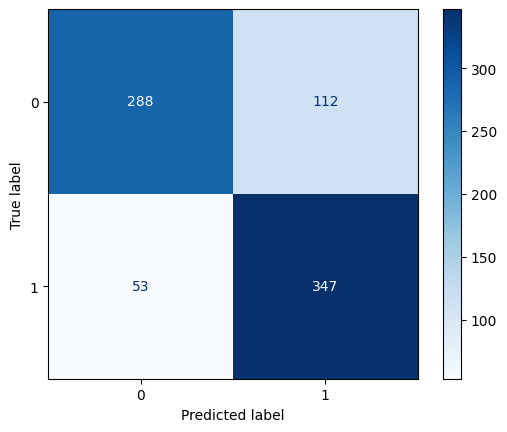

              precision    recall  f1-score   support

           0       0.84      0.72      0.78       400
           1       0.76      0.87      0.81       400

    accuracy                           0.79       800
   macro avg       0.80      0.79      0.79       800
weighted avg       0.80      0.79      0.79       800

ROC-AUC: 0.831


<Figure size 640x480 with 0 Axes>

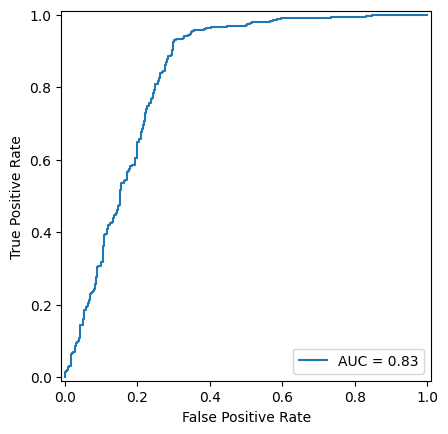

In [ ]:
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
)
# Evaluation on test set

model.eval()
all_probs = []
all_labels = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device_torch)
        yb = yb.to(device_torch)

        probs = model(xb)  # (batch_size, 1)
        all_probs.append(probs.cpu())
        all_labels.append(yb.cpu())

all_probs = torch.cat(all_probs, dim=0)
all_labels = torch.cat(all_labels, dim=0)

# Convert probabilities to class predictions
y_pred = (all_probs >= 0.5).int()
y_true = all_labels.int()

acc = accuracy_score(y_true.numpy(), y_pred.numpy())
cm = confusion_matrix(y_true.numpy(), y_pred.numpy())

print(f"Test accuracy: {acc:.3f}")
print("Confusion matrix [[TN, FP], [FN, TP]]:")
print(cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap="Blues")
plt.show()

print(classification_report(y_true.numpy(), y_pred.numpy()))


from sklearn.metrics import roc_curve, RocCurveDisplay, roc_auc_score

plt.figure()
# Compute ROC curve and ROC area for model
fpr, tpr, thresholds = roc_curve(y_true.numpy(), all_probs.numpy())
roc_auc = roc_auc_score(y_true.numpy(), all_probs.numpy())

print(f"ROC-AUC: {roc_auc:.3f}")

roc_disp = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
roc_disp.plot()
plt.show()


In [ ]:
# from sklearn.metrics import (
#     accuracy_score,
#     confusion_matrix,
#     ConfusionMatrixDisplay,
#     classification_report,
# )
# # Evaluation on test set

# model2.eval()
# all_probs = []
# all_labels = []

# with torch.no_grad():
#     for xb, yb in test_loader:
#         xb = xb.to(device_torch)
#         yb = yb.to(device_torch)

#         probs = model2(xb)  # (batch_size, 1)
#         all_probs.append(probs.cpu())
#         all_labels.append(yb.cpu())

# all_probs = torch.cat(all_probs, dim=0)
# all_labels = torch.cat(all_labels, dim=0)

# # Convert probabilities to class predictions
# y_pred = (all_probs >= 0.5).int()
# y_true = all_labels.int()

# acc = accuracy_score(y_true.numpy(), y_pred.numpy())
# cm = confusion_matrix(y_true.numpy(), y_pred.numpy())

# print(f"Test accuracy: {acc:.3f}")
# print("Confusion matrix [[TN, FP], [FN, TP]]:")
# print(cm)

# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
# disp.plot(cmap="Blues")
# plt.show()

# print(classification_report(y_true.numpy(), y_pred.numpy()))


# Classical Baseline: Random Forest

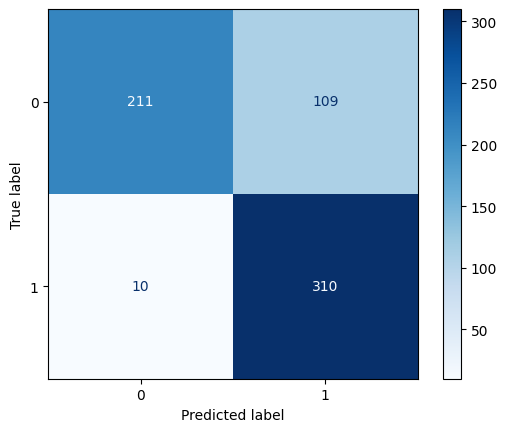

              precision    recall  f1-score   support

           0       0.95      0.66      0.78       320
           1       0.74      0.97      0.84       320

    accuracy                           0.81       640
   macro avg       0.85      0.81      0.81       640
weighted avg       0.85      0.81      0.81       640



In [ ]:
# Classical Baseline: CatBoost

from catboost import CatBoostClassifier

# Create CatBoost classifier
catboost_model = CatBoostClassifier(
    iterations=100,
    learning_rate=0.1,
    depth=4,
    verbose=False  # Suppress CatBoost output for cleaner notebook
)

# IMPORTANT: Use X_tr (scaled) for training since X_val was also scaled in Cell 11!
# X_train is unscaled, but X_val was overwritten with scaled data.
catboost_model.fit(X_tr, Y_train)

# Predict on scaled validation data (X_val is already scaled from Cell 11)
preds_class = catboost_model.predict(X_vl)
preds_proba = catboost_model.predict_proba(X_vl)
preds_raw = catboost_model.predict(X_vl, prediction_type='RawFormulaVal')

cm = confusion_matrix(Y_val, preds_class)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap="Blues")
plt.show()

print(classification_report(Y_val, preds_class))



ROC-AUC: 0.870


<Figure size 640x480 with 0 Axes>

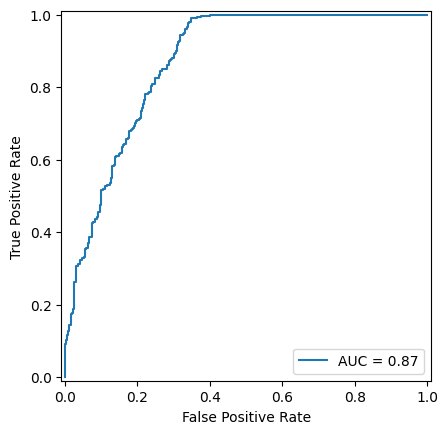

In [ ]:
plt.figure()
# Compute ROC curve and ROC area for model
fpr, tpr, thresholds = roc_curve(Y_val, preds_proba[:,1])
roc_auc = roc_auc_score(Y_val, preds_proba[:,1])

print(f"ROC-AUC: {roc_auc:.3f}")

roc_disp = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
roc_disp.plot()
plt.show()

In [ ]:
X_train.shape

(2560, 5)